# Aspect-Based Opinion Mining
The goal of this project is to predict aspects that are talked about in a given review about a resturant. 
We extracted reveiws for resturant from Yelp academic dataset and used Aylien Api to lable the the dataset. 
This turns into a multilable classifiction problem where each data point can belogn to multiple lables.

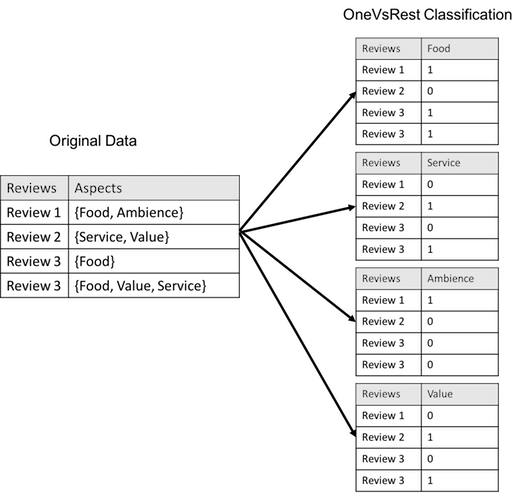

In [1]:
from IPython.core.display import Image, display
try:
    display(Image('overview.png',  unconfined=True))
except:
    pass

In [2]:
from nltk.corpus import wordnet
import os
import re
#import enchant
from langdetect import detect
import time
#enchant.set_param("enchant.myspell.dictionary.path",os.getcwd())
from nltk.metrics import edit_distance
import nltk.data
from nltk.util import ngrams
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import model_selection 
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.ensemble import RandomForestClassifier
import multiprocessing as mp
import matplotlib.pylab as plt
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.externals import joblib
import seaborn as sns
%matplotlib inline

In [3]:
def topn_features(vectorizer, clf, class_labels,n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print 'Top ' +str(n) + ' most informative features for each class'
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print '----------------------------------------------------------------------'
        print "%s %s" % (class_label + ':\n',
              " ".join(feature_names[j] for j in top10))
        
        
replacement_patterns = [   # list of patterns for changing short form to long form
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+t)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
]

def f_combine(food,ambience,service,value):
    cat = []
    if food ==1 :
        cat.append(0)
    if ambience==1:
        cat.append(1)
    if service ==1:
        cat.append(2)
    if value ==1:
        cat.append(3)
    return cat

def replacement(text,patterns): # changes short forms to the full form e.g. I'll not -> I will not
    s = text

    for (pattern, repl) in patterns:
        (s, count) = re.subn(pattern, repl, s)
    return s

def repeat_corrector(word):  # Replace the repeated pattern in a give word. e.g. Soooo niccceee -> so nice
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)


    if repl_word !=word :
        return repeat_corrector(repl_word)
    else:
        return repl_word
valance_shifter=set(['not','never','hardly','barely'])

def text_preprocess(text):
    # removing non-UTF characters
    text=re.sub(r'[^\x00-\x7F]+',' ', text)
     #check the language of the review, if this is not English go the to the next one
    text=replacement(text,replacement_patterns)


    # check the language of the file
    if detect(text)!='en':
        return 'Not in Enlish!'
    # removing all non-letter characters
    text = re.sub("[^0-9a-zA-Z-]+", ' ', text)

    # extracting all terms in each review
    terms = nltk.word_tokenize(text.lower())
  

    text_result= str()
 
    for term in terms:
        term=re.sub('[^a-z]','',term)
        if term in english_stopwords: # removing stop words
            continue
        term =repeat_corrector(term) # correctling words with repeation

        text_result=text_result+term + str(' ')



    return text_result

def precious_recall_plot(clfs,clf_names,X_test,Y_test):
    for clf,name in zip(clfs,clf_names):
        target = clf.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(Y_test, target[:,1])
        prc_auc = average_precision_score(Y_test, target[:,1])
        plt.plot(recall, precision, label=name+' (area = %0.3f)' % prc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")

    plt.show()
    

# Reading and Preprocessing the Data
We prepare the tokenizers, count the number of cores on the machine for parallization of our calculation and read the data set. 
We use our custom made preprocessor to preprocess the text

In [4]:
core_count= mp.cpu_count()
stemmer = nltk.stem.porter.PorterStemmer()
sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
english_stopwords=set(stopwords.words('english'))

df = pd.read_csv('PreprocessedData.csv')
df['processed_text'] =df.text.apply(text_preprocess)
'Number of Training Examples:', df.shape[0]

('Number of Training Examples:', 6794)

# Extracting Features from Text
First we combine different categories into one variable then transform it into a binary array. Then vectorizee the text using the tfidf

In [7]:
Y =MultiLabelBinarizer().fit_transform(
    df.apply(lambda x: f_combine(x.food, x.ambience,x.service,x.value), axis=1)
    )

vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df= 1.0)
vectorizer.fit(df['processed_text'])
X=vectorizer.transform (df['processed_text'])



# Comparing Performance of different Classifiers
To classifier each data point into multiple lables, we use OneVsRestClassifier along with different classifiers. This helps use to train a classifier per each categorry. As the metric for measuring the performance of the models, we use hamming_loss. Hamming loss represent the avarage number of lables that are incorrectly classified. 

In [10]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=20)
classifiers={ 'LinearSVC': LinearSVC(random_state=0), 'SGDclassifier':SGDClassifier(alpha=0.000001,penalty="l2"), 
           'NaiveBayes':MultinomialNB(),'KNN':KNeighborsClassifier() }
performance ={}
for name, classifier in classifiers.iteritems():
    
    print 'Training ',name,'...'
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    performance[name]=hamming_loss(Y_test, Y_pred)
print 'training completed'

Training  KNN ...
Training  LinearSVC ...
Training  SGDclassifier ...
Training  NaiveBayes ...


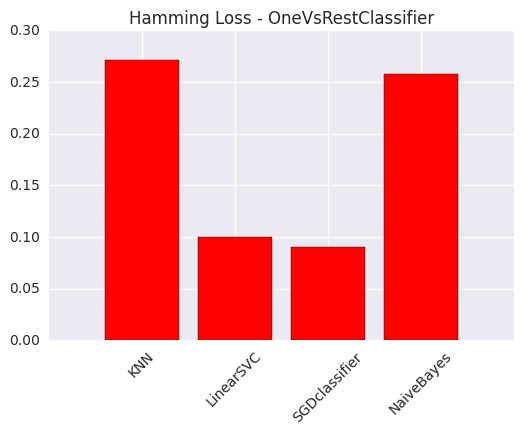

In [11]:
fig=plt.figure()
sns.set_style("darkgrid")
plt.title("Hamming Loss - OneVsRestClassifier")
plt.bar( range(len(performance)),list(performance.itervalues()),   color="r",  align="center")
plt.xticks(range(len(performance)), list(performance.iterkeys()),rotation=45)
plt.xlim([-1,len(performance)] )
plt.show()

# Tuning Hyper Parameters
The result shows that SGD classifier ( which is basically an implemention of linear SVM) does a better job with the classification task of the text data (this is often the case with text classification).
Now, we go ahead and train the hyper parameters of the classifier using GridSearch and CV.

In [19]:
tuned_parameters = [{'estimator__alpha': [0.001, 0.01,0.1,0.5] ,
'estimator__penalty': ['l1','l2','elasticnet'],
'estimator__loss':['log','modified_huber']}]
scores =['preceision']#['precision', 'recall']
estimator = OneVsRestClassifier(SGDClassifier(random_state=0,learning_rate='optimal',class_weight='balanced',n_iter=100))
estimator.get_params().keys()
gsearch = GridSearchCV(estimator,tuned_parameters, cv=5,scoring='average_precision',n_jobs=core_count)
gsearch.fit(X_train,Y_train)
print gsearch.best_score_
print gsearch.best_params_

0.983167335053
{'estimator__alpha': 0.001, 'estimator__penalty': 'l1', 'estimator__loss': 'modified_huber'}


# Top Informative Features for Each Aspect
We train our model using the optimized paramters obtain from the GridSearch. Now, we can find a the most informative features in for each category.

In [14]:
best_classifier=OneVsRestClassifier(SGDClassifier(alpha= 0.001,penalty="l1",random_state=0,learning_rate='optimal',class_weight='balanced',
                                                 loss='modified_huber',n_iter=100))
best_classifier.fit(X_train,Y_train)
features =  ['Food','Ambience','Service','Value' ]
topn_features(vectorizer, best_classifier,features,n=10)

Top 10 most informative features for each class
----------------------------------------------------------------------
Food:
 meal cheese better sushi breakfast lunch chicken delicious good food
----------------------------------------------------------------------
Ambience:
 loud greasy empty near waiting clean busy location area wait
----------------------------------------------------------------------
Service:
 parking choice waiter options waitress server friendly staff menu service
----------------------------------------------------------------------
Value:
 cash cost pricey priced expensive deal cheap prices price worth


# Precision-Recall Curve
Lets evaluate the performance of the classifier for each category

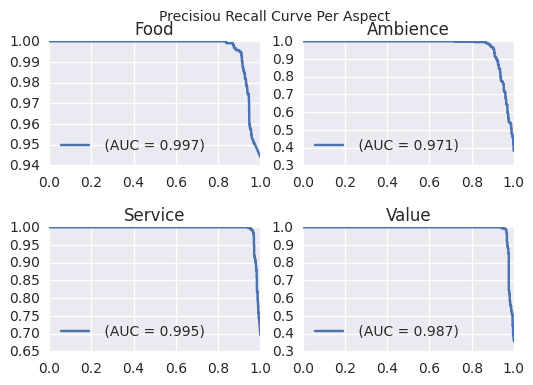

In [15]:
Y_pred_proba = best_classifier.predict_proba(X_test)
params = {'legend.fontsize': 10,}

f, axarr = plt.subplots(2, 2)
plt.subplots_adjust(hspace=.5)
sns.set_style("darkgrid")
plt.suptitle('Precisiou Recall Curve Per Aspect')
k=0
for i in range(0,2):
    for j in range(0,2):
        plt.rcParams.update(params)
        precision, recall, _ = precision_recall_curve(Y_test[:,k], Y_pred_proba[:,k])
        prc_auc = average_precision_score(Y_test[:,k], Y_pred_proba[:,k])
        axarr[i, j].plot(recall, precision, label=' (AUC = %0.3f)' % prc_auc)
        axarr[i, j].set_title(features[k])
        axarr[i, j].legend(loc="lower left")
        k+=1
        

# ROC Curve

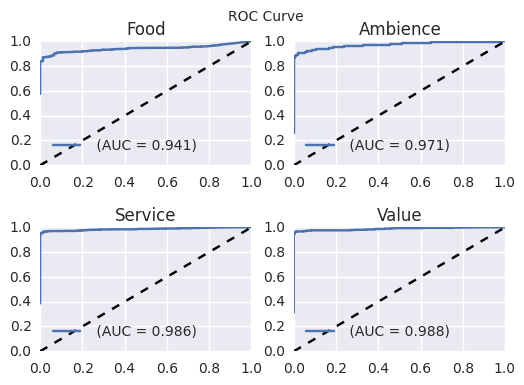

In [16]:
f, axarr = plt.subplots(2, 2)
plt.subplots_adjust(hspace=.5)
sns.set_style("darkgrid")
plt.suptitle('ROC Curve')
k=0
for i in range(0,2):
    for j in range(0,2):
        plt.rcParams.update(params)
        
        fpr, tpr, _ = roc_curve(Y_test[:,k], Y_pred_proba[:,k])
        roc_auc = auc(fpr, tpr)
        axarr[i, j].plot(fpr, tpr, label=' (AUC = %0.3f)' % roc_auc)
        axarr[i, j].set_title(features[k])
        axarr[i, j].plot([0, 1], [0, 1], 'k--') 
        axarr[i, j].legend(loc="lower left")
        k+=1
        

# Creating Pipeline for the Best Performed Classifier
We create a pipline and save our model

In [17]:
classifier_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2),max_df= 1.0)),
    ('clf',OneVsRestClassifier(SGDClassifier(alpha= 0.001,penalty="l1",random_state=0,learning_rate='optimal',

                                             class_weight='balanced', loss='modified_huber',n_iter=100)))])
classifier_pipe.fit(df['processed_text'],Y)
joblib.dump(classifier_pipe,'MultiLable_Classifier.pkl')



['MultiLable_Classifier.pkl']

# Testing the Model on Unseen Data
we test our model for unseen piece of text and calculate the probablity of belonging to each category

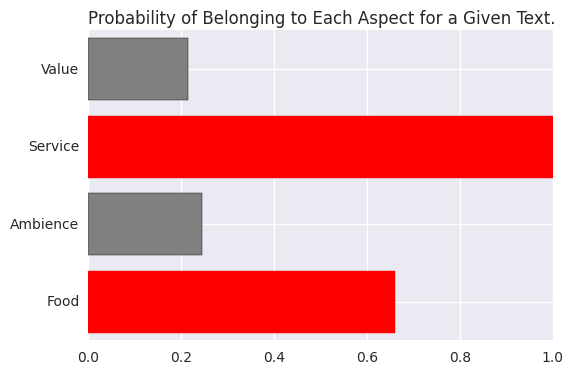

In [18]:
classifier_pipe=joblib.load('MultiLable_Classifier.pkl')
probs=classifier_pipe.predict_proba(['Two stars at best.  Service was slow and poor. Food was marginal at best. Came here in hopes of being quick and decent and was disappointed on both accounts. Pass on this place no matter how hungry or tired you might be.'])
ax = plt.plot()  
plt.title("Probability of Belonging to Each Aspect for a Given Text.")
sns.set_style("darkgrid")

barlist=plt.barh( range(len(features)),probs.tolist()[0],   color="gray",  align="center")
for i,_ in enumerate(features):
    if probs.tolist()[0][i]>.5:
        barlist[i].set_color('r')

plt.yticks(range(len(features)), features)
plt.xlim([0,1] )
plt.show()

